In [2]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from sklearn import decomposition
from scipy.optimize import least_squares
import geopandas as gpd
from requests import get,Session
import wget
from census import Census
from us import states
import folium
%matplotlib inline

In [85]:
# read in 2016 census tract shapefile (from https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html)
gdf = gpd.read_file('/Users/nehrkorn/Downloads/cb_2016_06_tract_500k/cb_2016_06_tract_500k.shp')
keep_cols = ['GEOID','ALAND', 'AWATER', 'geometry']
gdf = gdf[keep_cols]

Variable code | Census description 
:---|:---
DP05_0082E | Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population
DP03_0032E | Estimate!!INDUSTRY!!Civilian employed population 16 years and over 
DP03_0033PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining 
DP03_0034PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Construction 
DP03_0035PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Manufacturing 
DP03_0036PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Wholesale trade 
DP03_0037PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Retail trade 
DP03_0038PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Transportation and warehousing, and utilities 
DP03_0039PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Information 
DP03_0040PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Finance and insurance, and real estate and rental and leasing 
DP03_0041PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services 
DP03_0042PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance 
DP03_0043PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Arts, entertainment, and recreation, and accommodation and food services 
DP03_0044PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Other services, except public administration 
DP03_0045PE | Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Public administration 
DP03_0096PE | Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage 
DP03_0099PE | Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!No health insurance coverage 
DP03_0062E | Estimate!!INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars) 
DP03_0063E | Estimate!!INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars) 
DP05_0017E | Estimate!!SEX AND AGE!!Median age (years) 
DP05_0018PE | Percent!!SEX AND AGE!!18 years and over 
DP05_0020PE | Percent!!SEX AND AGE!!62 years and over 
DP03_0119PE | Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All families 

In [51]:
census_vars_dict = {'DP05_0082E':'dp_pop_voting_age',
                    'DP03_0032E':'dp_pop_employed',
                    'DP03_0033PE':'dp_pct_industry_farming',
                    'DP03_0034PE':'dp_pct_industry_construction',
                    'DP03_0035PE':'dp_pct_industry_manufacturing',
                    'DP03_0036PE':'dp_pct_industry_wholesale',
                    'DP03_0037PE':'dp_pct_industry_retail',
                    'DP03_0038PE':'dp_pct_industry_transportation',
                    'DP03_0039PE':'dp_pct_industry_information',
                    'DP03_0040PE':'dp_pct_industry_finance',
                    'DP03_0041PE':'dp_pct_industry_professional',
                    'DP03_0042PE':'dp_pct_industry_education',
                    'DP03_0043PE':'dp_pct_industry_arts',
                    'DP03_0044PE':'dp_pct_industry_services',
                    'DP03_0045PE':'dp_pct_industry_publicadmin',
                    'DP03_0096PE':'dp_pct_healthinsurance_yes',
                    'DP03_0099PE':'dp_pct_healthinsurance_no',
                    'DP03_0062E':'dp_median_household_income',
                    'DP03_0063E':'dp_mean_household_income',
                    'DP05_0017E':'dp_median_age',
                    'DP05_0018PE':'dp_pct_age_18plus',
                    'DP05_0020PE':'dp_pct_age_62plus',
                    'DP03_0119PE':'dp_pct_familiesbelowFPL'}

In [52]:
# get name and desired stats for all tracts in CA (list of dicts)
c = Census("fc40d0e5624aa1c5f10cb80e68c8a62d1d5bdc68")
result = c.acs5dp.get(['NAME']+list(census_vars_dict.keys()),
                      geo={'for': 'tract:*',
                           'in': 'state:{}'.format(states.CA.fips)})

[{'DP03_0032E': 1568.0,
  'DP03_0033PE': 0.6,
  'DP03_0034PE': 2.2,
  'DP03_0035PE': 5.9,
  'DP03_0036PE': 2.6,
  'DP03_0037PE': 10.5,
  'DP03_0038PE': 4.6,
  'DP03_0039PE': 3.8,
  'DP03_0040PE': 14.8,
  'DP03_0041PE': 24.9,
  'DP03_0042PE': 24.6,
  'DP03_0043PE': 1.6,
  'DP03_0044PE': 2.1,
  'DP03_0045PE': 1.9,
  'DP03_0062E': 177417.0,
  'DP03_0063E': 247448.0,
  'DP03_0096PE': 96.4,
  'DP03_0099PE': 3.6,
  'DP03_0119PE': 3.0,
  'DP05_0017E': 54.2,
  'DP05_0018PE': 87.2,
  'DP05_0020PE': 31.5,
  'DP05_0082E': 2423.0,
  'NAME': 'Census Tract 4001, Alameda County, California',
  'county': '001',
  'state': '06',
  'tract': '400100'},
 {'DP03_0032E': 1229.0,
  'DP03_0033PE': 0.5,
  'DP03_0034PE': 4.5,
  'DP03_0035PE': 4.5,
  'DP03_0036PE': 0.0,
  'DP03_0037PE': 5.0,
  'DP03_0038PE': 1.9,
  'DP03_0039PE': 8.7,
  'DP03_0040PE': 9.5,
  'DP03_0041PE': 24.1,
  'DP03_0042PE': 26.5,
  'DP03_0043PE': 5.9,
  'DP03_0044PE': 7.2,
  'DP03_0045PE': 1.8,
  'DP03_0062E': 153125.0,
  'DP03_0063E': 1884

In [55]:
# make dataframe out of results
df = pd.DataFrame(result)
# add a tract code column that matches the census tract shapefile (for merging)
df['GEOID'] = df.state+df.county+df.tract
# rename column names with human-readable variable titles
df.rename(index=str,columns=census_vars_dict,inplace=True)
df

,dp_pop_employed,dp_pct_industry_farming,dp_pct_industry_construction,dp_pct_industry_manufacturing,dp_pct_industry_wholesale,dp_pct_industry_retail,dp_pct_industry_transportation,dp_pct_industry_information,dp_pct_industry_finance,dp_pct_industry_professional,...,dp_pct_familiesbelowFPL,dp_median_age,dp_pct_age_18plus,dp_pct_age_62plus,dp_pop_voting_age,NAME,county,state,tract,GEOID
0,1568.0,0.6,2.2,5.9,2.6,10.5,4.6,3.8,14.8,24.9,...,3.0,54.2,87.2,31.5,2423.0,"Census Tract 4001, Alameda County, California",001,06,400100,06001400100
1,1229.0,0.5,4.5,4.5,0.0,5.0,1.9,8.7,9.5,24.1,...,1.1,43.6,82.9,24.9,1537.0,"Census Tract 4002, Alameda County, California",001,06,400200,06001400200
2,3198.0,0.8,2.1,6.2,0.9,4.8,2.5,2.8,12.3,25.9,...,3.6,41.3,82.4,15.2,3997.0,"Census Tract 4003, Alameda County, California",001,06,400300,06001400300
3,2564.0,0.5,2.7,1.1,3.9,4.0,3.0,5.7,4.3,20.8,...,0.9,36.6,84.3,14.7,3326.0,"Census Tract 4004, Alameda County, California",001,06,400400,06001400400
4,2463.0,0.8,5.9,3.0,4.9,8.2,4.9,4.7,5.1,18.3,...,5.8,34.1,86.7,12.3,2850.0,"Census Tract 4005, Alameda County, California",001,06,400500,06001400500
5,1012.0,0.0,5.8,6.0,1.0,10.1,1.8,4.8,4.7,12.5,...,3.3,34.8,86.0,12.7,1366.0,"Census Tract 4006, Alameda County, California",001,06,400600,06001400600
6,2485.0,0.0,4.4,4.1,0.9,13.9,3.7,2.4,2.3,15.7,...,12.3,35.9,83.7,15.1,3458.0,"Census Tract 4007, Alameda County, California",001,06,400700,06001400700
7,2087.0,0.9,7.1,4.6,0.0,7.1,5.7,3.5,7.6,18.4,...,7.4,37.0,88.2,16.7,2839.0,"Census Tract 4008, Alameda County, California",001,06,400800,06001400800
8,1373.0,0.0,5.0,5.7,2.1,9.0,2.0,3.6,6.4,27.5,...,10.5,36.1,81.9,12.8,1650.0,"Census Tract 4009, Alameda County, California",001,06,400900,06001400900
9,3621.0,0.0,5.3,5.1,5.5,6.7,4.7,3.1,6.8,18.2,...,19.9,36.0,86.8,9.7,4896.0,"Census Tract 4010, Alameda County, California",001,06,401000,06001401000


dp_pct_age_18plus
dp_pct_industry_education
dp_pct_healthinsurance_no
dp_pct_familiesbelowFPL
dp_pct_industry_publicadmin
dp_pct_industry_finance
dp_pct_industry_professional
dp_pct_industry_transportation
dp_pop_employed
dp_median_household_income
dp_pct_industry_services
dp_pct_industry_retail
dp_pct_industry_farming
dp_pop_voting_age
dp_mean_household_income
dp_pct_industry_construction
dp_pct_industry_information
dp_median_age
dp_pct_industry_arts
dp_pct_healthinsurance_yes
dp_pct_age_62plus
dp_pct_industry_wholesale
dp_pct_industry_manufacturing


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


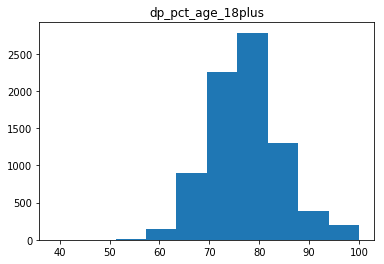

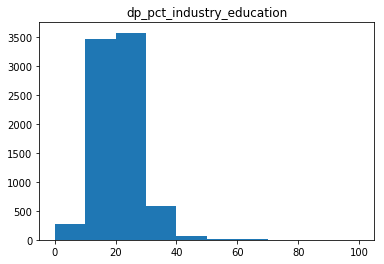

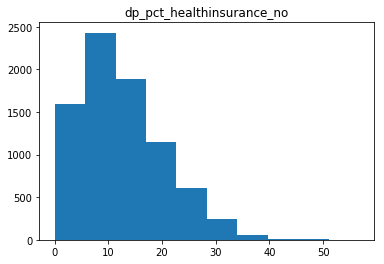

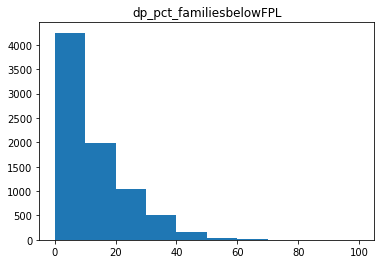

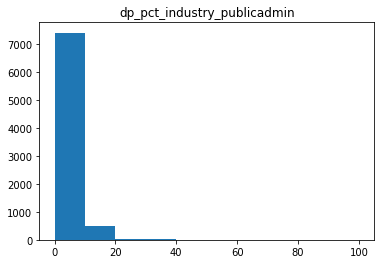

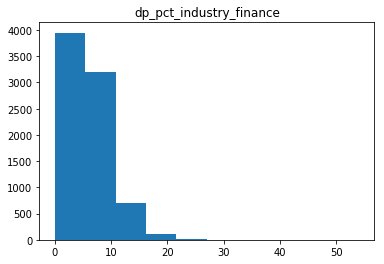

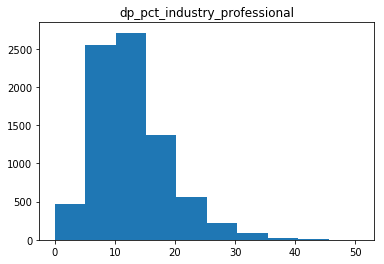

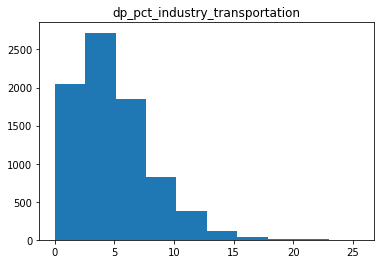

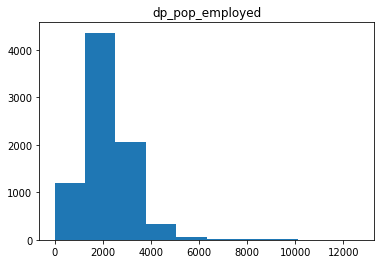

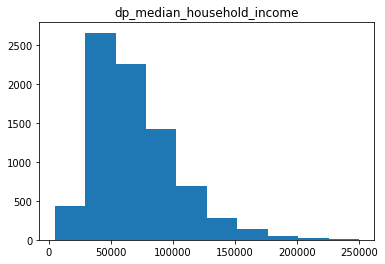

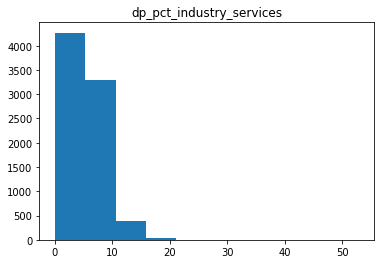

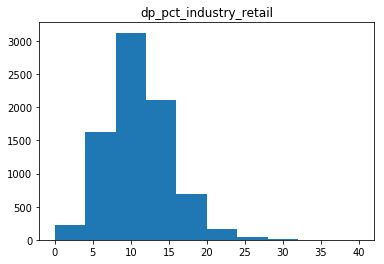

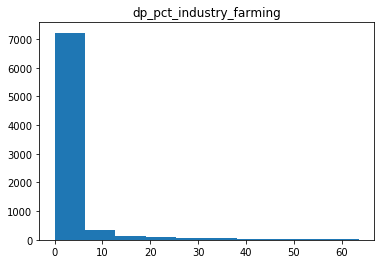

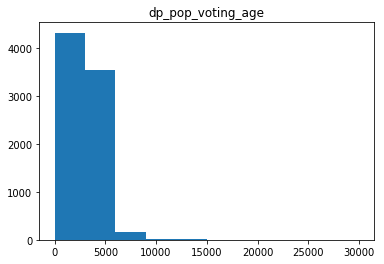

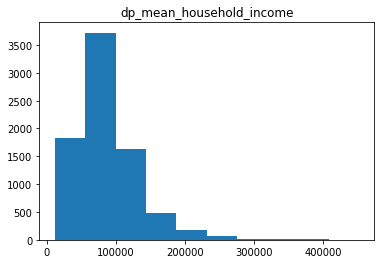

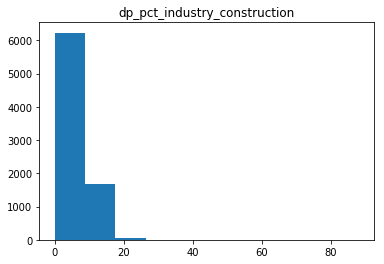

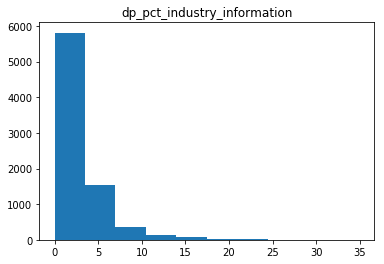

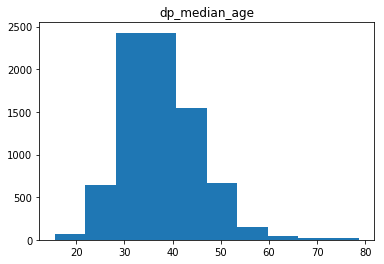

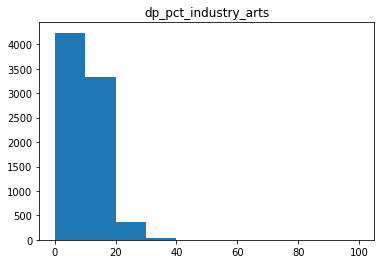

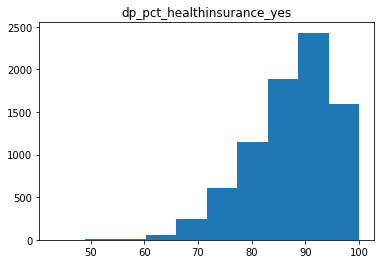

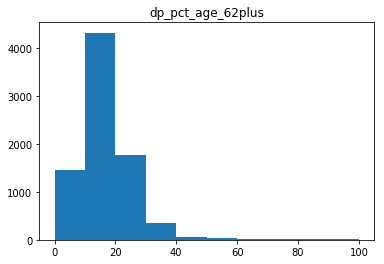

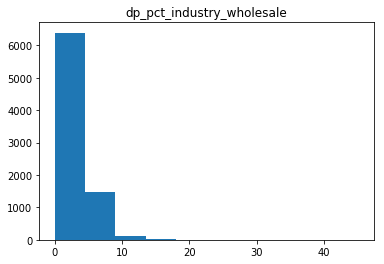

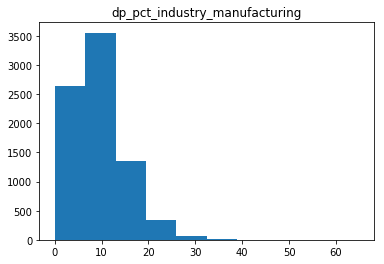

In [80]:
# turn error code entries into NaNs
for census_stat in census_vars_dict.values():
    print(census_stat)
    df.loc[df[census_stat] < -1000,census_stat] = np.nan
    x = df[census_stat].dropna()
    plt.figure()
    plt.hist(x)
    plt.title(census_stat)

In [86]:
# merge census data with shapefile
gdf_merge_census = pd.merge(gdf,df,on='GEOID',how='inner')
gdf_merge_census

,GEOID,ALAND,AWATER,geometry,dp_pop_employed,dp_pct_industry_farming,dp_pct_industry_construction,dp_pct_industry_manufacturing,dp_pct_industry_wholesale,dp_pct_industry_retail,...,dp_pct_healthinsurance_no,dp_pct_familiesbelowFPL,dp_median_age,dp_pct_age_18plus,dp_pct_age_62plus,dp_pop_voting_age,NAME,county,state,tract
0,06013359103,2593523,1170833,"POLYGON ((-122.302287 37.995278, -122.299658 3...",2640.0,0.0,5.8,10.3,1.3,9.8,...,7.1,7.3,42.5,84.6,20.4,3857.0,"Census Tract 3591.03, Contra Costa County, Cal...",013,06,359103
1,06013366001,1017166,0,"POLYGON ((-122.353307 37.978544, -122.352953 3...",1952.0,1.6,11.2,7.0,6.2,10.0,...,13.6,8.4,36.6,76.7,11.9,2553.0,"Census Tract 3660.01, Contra Costa County, Cal...",013,06,366001
2,06013374000,992095,0,"POLYGON ((-122.347509 37.939984, -122.347471 3...",1911.0,1.8,14.6,9.8,1.9,9.9,...,10.1,14.8,39.1,78.8,17.8,2444.0,"Census Tract 3740, Contra Costa County, Califo...",013,06,374000
3,06013388000,659857,0,"POLYGON ((-122.308489 37.911273, -122.304275 3...",1432.0,0.0,6.1,2.5,1.0,4.5,...,13.2,6.8,37.0,81.4,16.2,1876.0,"Census Tract 3880, Contra Costa County, Califo...",013,06,388000
4,06017030710,7898800,0,"POLYGON ((-121.081663 38.692493, -121.079227 3...",2120.0,0.3,1.5,9.5,4.1,7.7,...,2.0,0.9,46.7,76.3,19.5,3546.0,"Census Tract 307.10, El Dorado County, California",017,06,030710
5,06017031402,788931825,156657,"POLYGON ((-120.84683 38.558447, -120.845074 38...",1943.0,1.1,18.3,6.8,3.2,9.6,...,12.1,14.2,52.9,84.3,26.1,4242.0,"Census Tract 314.02, El Dorado County, California",017,06,031402
6,06019000300,1887566,0,"POLYGON ((-119.813029 36.72862, -119.805003 36...",1099.0,11.2,0.0,13.0,1.5,5.4,...,18.5,31.8,29.5,70.5,14.3,1835.0,"Census Tract 3, Fresno County, California",019,06,000300
7,06019000901,1954608,0,"POLYGON ((-119.817891 36.714015, -119.808901 3...",904.0,21.0,4.0,8.7,2.9,10.7,...,19.7,45.2,22.3,58.5,5.3,1193.0,"Census Tract 9.01, Fresno County, California",019,06,000901
8,06019001408,1218706,0,"POLYGON ((-119.7364 36.728666, -119.731949 36....",696.0,1.1,4.5,6.9,4.6,12.5,...,9.5,28.0,60.3,91.0,47.5,1933.0,"Census Tract 14.08, Fresno County, California",019,06,001408
9,06019002300,1496251,0,"POLYGON ((-119.802846 36.754879, -119.80029 36...",1329.0,2.7,2.6,5.6,2.3,7.8,...,17.4,35.1,31.1,74.3,13.1,2077.0,"Census Tract 23, Fresno County, California",019,06,002300


In [90]:
m = folium.Map([37.166111, -119.449444], zoom_start=5)

#geo_data = folium.GeoJson(gdf_merge_census)

m.choropleth(geo_data = gdf_merge_census.to_json(), data = gdf_merge_census,
             columns = ['GEOID','dp_median_household_income'], key_on = 'feature.properties.GEOID',
             fill_color='YlGn',
             highlight=True)

m.save('test.html')